In [1]:
import sys
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from ppg_dataset import PPGDataset

import config

sys.path.append(os.path.join(os.path.curdir, 'trained_model'))

from trained_model.src.models.utils import load_model
import trained_model.utils.consts as consts

from sklearn import metrics
from sklearn.preprocessing import normalize, StandardScaler

from tabulate import tabulate

# reset the matplotlib settings to default
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

import warnings
warnings.filterwarnings('ignore')

/Users/snirlugassy/miniconda3/envs/deep/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Load all RR windows from UMMC PPG signals

In [2]:
dataset = PPGDataset('data', freq=config.DFS, peak_detector='elgendi')
dataset.process_signals()
all_windows = [x for x in dataset]

# 60 RR windows
X = [w[0] for w in all_windows]

# divide by 1000 for the right time units
X = np.vstack(X) / 1000

# Ground truth for each window (0=No-AF, 1=AF)
y = np.array([w[1] for w in all_windows])

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (1698, 60), y shape: (1698,)


In [3]:
def eval_af_predictions(y_true, y_score, threshold=None):
    """
    Evaluate predictions
    y_true: binary array with the ground truth labels
    y_score: array with the score (p(x=1)) of each window
    threshold: the classification threshold [ y_predict = y_score >= threshold ]
    """
    fpr, tpr, thrs = metrics.roc_curve(y_true, y_score)
    plt.figure(figsize=(4,4))
    plt.title("ROC Curve")
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

    linspace = np.linspace(0,1,100)
    f1s = [metrics.f1_score(y_true, 1 * (y_score >= th), zero_division=0) for th in linspace]
    recall = [metrics.recall_score(y_true, 1 * (y_score >= th), zero_division=0) for th in linspace]
    precision = [metrics.precision_score(y_true, 1 * (y_score >= th), zero_division=0) for th in linspace]
    plt.figure(figsize=(4,3))
    plt.title("Optimal threshold for scores")
    plt.plot(linspace, f1s)
    plt.plot(linspace, recall)
    plt.plot(linspace, precision)
    plt.legend(['F1', 'Recall', 'Precision'])
    plt.xlabel('Threshold')
    plt.ylabel('Scores')
    plt.show()

    best_f1_idx = np.argmax(f1s)
    best_f1_th = linspace[best_f1_idx]

    if threshold is None:
        threshold = best_f1_th
    
    print('Using threshold ', threshold)

    y_predict = 1 * (y_score >= threshold)
    print(set(y_predict))
    scores_table = []
    scores_table.append(['Accuracy', metrics.accuracy_score(y_true, y_predict)])
    scores_table.append(['Precision', metrics.precision_score(y_true, y_predict, zero_division=0)])
    scores_table.append(['Recall', metrics.recall_score(y_true, y_predict, zero_division=0)])
    scores_table.append(['F1', metrics.f1_score(y_true, y_predict, zero_division=0)])
    scores_table.append(['ROC AUC', metrics.roc_auc_score(y_true, y_score)])
    print(tabulate(scores_table))

    print('Confusion Matrix:')
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_predict).ravel()
    print(tabulate([
        [f'TP {tp}', f'FN {fn}'],
        [f'FP {fp}', f'TN {tn}']

    ]))

    # # fprs = [metrics.fall(y_true, 1 * (y_score >= th)) for th in linspace]
    # plt.figure(figsize=(5,3))
    # plt.title("Optimal threshold for FPR (False alarm)")
    # plt.plot(thrs, fpr)
    # plt.xlabel('Threshold')
    # plt.ylabel('FPR')
    # plt.show()


### AF Prediction using 1D-CNN
Chocron, et al. 
Remote atrial fibrillation burden estimation using deep recurrent neural network
https://doi.org/10.48550/arXiv.2008.02228



54/54 [==============================] - 1s 10ms/step


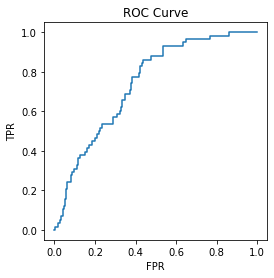

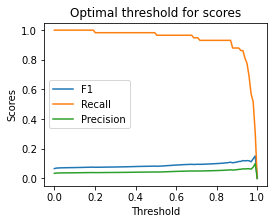

Using threshold  0.56146777
{0, 1}
---------  ---------
Accuracy   0.301531
Precision  0.0451613
Recall     0.965517
F1         0.0862866
ROC AUC    0.739108
---------  ---------
Confusion Matrix:
-------  ------
TP 56    FN 2
FP 1184  TN 456
-------  ------


In [4]:
# Load 1D-CNN
pretrained_1 = load_model(consts.path_models['1D-CNN'], algo='1D-CNN')
af_1d_cnn = pretrained_1['classifier']
best_th = pretrained_1['best_th']

x = X.reshape(X.shape[0], X.shape[1], 1)
y_score = af_1d_cnn.model.predict(x).reshape(-1)

eval_af_predictions(y, y_score, threshold=best_th)

### Using ResNet 1D-CNN
( Shany's )

54/54 [==============================] - 1s 18ms/step


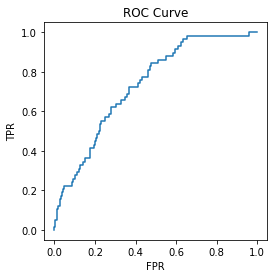

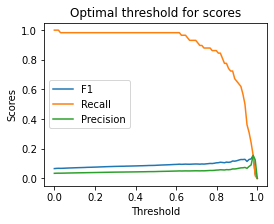

Using threshold  0.5072552
{0, 1}
---------  ---------
Accuracy   0.310365
Precision  0.0464548
Recall     0.982759
F1         0.088716
ROC AUC    0.733106
---------  ---------
Confusion Matrix:
-------  ------
TP 57    FN 1
FP 1170  TN 470
-------  ------


In [5]:
# Load 1D-CNN ResNet
pretrained_2 = load_model(consts.path_models['ResNet'], algo='ResNet')
resnet_1d_cnn = pretrained_2['classifier']
best_th = pretrained_2['best_th']

x = X.reshape(X.shape[0], X.shape[1], 1)
y_score = resnet_1d_cnn.model.predict(x).reshape(-1)

eval_af_predictions(y, y_score, threshold=best_th)

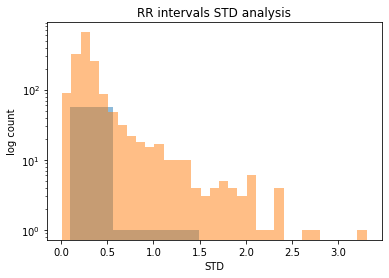

In [6]:
std = np.std(X, axis=1)
C = []
for _y in y:
    if _y > 0:
        C.append('r')
    else:
        C.append('b')

AF_std = np.std(X[y==1], axis=1)
NON_AF_std = np.std(X[y==0], axis=1)

plt.title('RR intervals STD analysis')
plt.xlabel('STD')
plt.ylabel('log count')
# plt.hist(std, bins=33, log=True)
plt.hist(AF_std, bins=3, log=True, alpha=0.5)
plt.hist(NON_AF_std, bins=33, log=True, alpha=0.5)
plt.show()

In [7]:
std_th = np.quantile(X.std(axis=1), 0.9)
std_th

# 1=keep, 0=ignore
# use this mask as follows:
# y_score = y_score * ignore_mask
ignore_mask = 1 - 1 * (X.std(axis=1) > std_th)
ignore_mask

array([0, 1, 1, ..., 1, 1, 1])

54/54 [==============================] - 1s 9ms/step


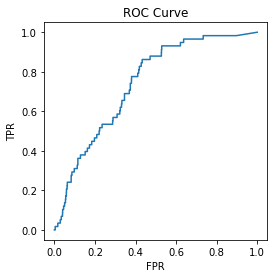

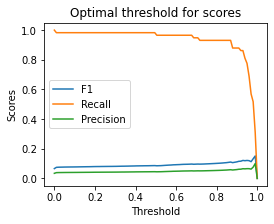

Using threshold  0.5072552
{0, 1}
---------  ---------
Accuracy   0.293286
Precision  0.0446571
Recall     0.965517
F1         0.0853659
ROC AUC    0.740144
---------  ---------
Confusion Matrix:
-------  ------
TP 56    FN 2
FP 1198  TN 442
-------  ------


In [8]:
y_score = af_1d_cnn.model.predict(x).reshape(-1)
y_score = y_score * ignore_mask

eval_af_predictions(y, y_score, threshold=best_th)

In [ ]:
std_th = np.quantile(X.std(axis=1), 0.9)
std_th

# 1=keep, 0=ignore
# use this mask as follows:
# y_score = y_score * ignore_mask
ignore_mask = 1 - 1 * (X.std(axis=1) > std_th)

y_score = af_1d_cnn.model.predict(x).reshape(-1)
y_score = y_score * ignore_mask

eval_af_predictions(y, y_score, threshold=best_th)

In [10]:
def rmssd(rr):
    diff = [rr[i] - rr[i-1] for i in range(1, len(rr))]
    return np.sqrt(np.mean(np.square(diff)))

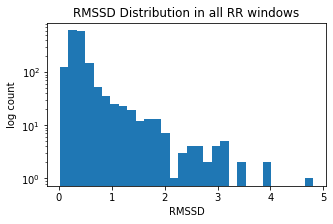

In [11]:
all_windows_rmssd = [rmssd(X[i]) for i in range(len(X))]

plt.figure(figsize=(5,3))
plt.title('RMSSD Distribution in all RR windows')
plt.xlabel('RMSSD')
plt.ylabel('log count')
plt.hist(all_windows_rmssd, bins=30, log=True)
plt.show()

54/54 [==============================] - 1s 16ms/step


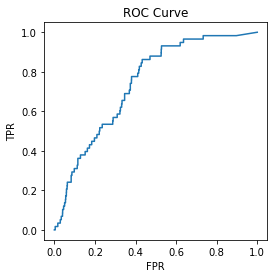

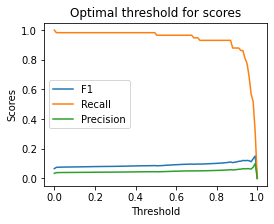

Using threshold  0.5072552
{0, 1}
---------  ---------
Accuracy   0.293286
Precision  0.0446571
Recall     0.965517
F1         0.0853659
ROC AUC    0.740112
---------  ---------
Confusion Matrix:
-------  ------
TP 56    FN 2
FP 1198  TN 442
-------  ------


In [12]:
bad_rmssd = np.quantile(all_windows_rmssd, 0.9)
ignore_mask = 1 - 1 * (np.array(all_windows_rmssd) > bad_rmssd)

y_score = af_1d_cnn.model.predict(x).reshape(-1)
y_score = y_score * ignore_mask

eval_af_predictions(y, y_score, threshold=best_th)

In [ ]:
y_score = resnet_1d_cnn.model.predict(x).reshape(-1)
y_score = y_score * ignore_mask

eval_af_predictions(y, y_score, threshold=best_th)

In [ ]:
y_score = resnet_1d_cnn.model.predict(x).reshape(-1)
y_score = y_score * ignore_mask

eval_af_predictions(y, y_score, threshold=best_th)

### Using ArNet2

In [13]:
model = load_model('trained_model/saved_models/ArNet2/ArNet2.pkl', algo='ArNet2', path_feature_extractor=consts.path_models['ResNet'])
arnet2_resnet_best_th = model['best_th']
arnet2_resnet = model['classifier']

In [14]:
model = load_model('trained_model/saved_models/ArNet/ArNet2.pkl', algo='ArNet2', path_feature_extractor=consts.path_models['1D-CNN'])
arnet2_1dcnn_best_th = model['best_th']
arnet2_1dcnn = model['classifier']

In [15]:
X = []
y = []
patient_global_label = {}
for w in all_windows:
    _x, _gt, _prec, _id = w
    y.append(_gt)
    if _id not in patient_global_label:
        patient_global_label[_id] = 0
    
    if _gt == 1:
        patient_global_label[_id] = 1

for w in all_windows:
    _x, _gt, _prec, _id = w
    X.append(np.hstack( [_x/1000, _prec, patient_global_label[_id], _id] ))

X = np.vstack(X)
X.shape, X


((1698, 63),
 array([['1.46', '0.76', '1.86', ..., '0', '0', '4008'],
        ['0.66', '1.32', '0.64', ..., '1', '0', '4008'],
        ['1.08', '1.24', '0.72', ..., '2', '0', '4008'],
        ...,
        ['0.5', '0.32', '0.48', ..., '58', '1', '4007'],
        ['0.32', '0.34', '0.32', ..., '59', '1', '4007'],
        ['0.64', '0.34', '0.5', ..., '60', '1', '4007']], dtype='<U32'))

### ArNet2 with 1D-CNN feature extractor

2/2 [==============================] - 1s 212ms/step


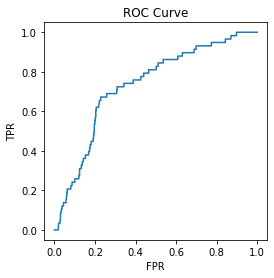

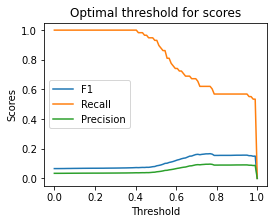

Using threshold  0.5126305222511292
{0, 1}
---------  ---------
Accuracy   0.349823
Precision  0.0452174
Recall     0.896552
F1         0.0860927
ROC AUC    0.731891
---------  ---------
Confusion Matrix:
-------  ------
TP 52    FN 6
FP 1098  TN 542
-------  ------


In [16]:
y_score = arnet2_1dcnn.predict_proba(X)[:, 1]
eval_af_predictions(y, y_score, arnet2_1dcnn_best_th)

### ArNet2 with ResNet feature extractor

2/2 [==============================] - 1s 231ms/step


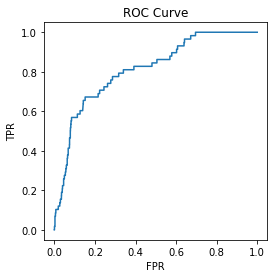

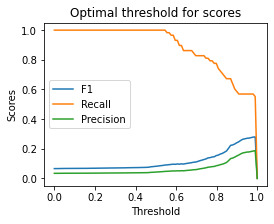

Using threshold  0.46823155879974365
{0, 1}
---------  ---------
Accuracy   0.184335
Precision  0.040194
Recall     1
F1         0.0772818
ROC AUC    0.810934
---------  ---------
Confusion Matrix:
-------  ------
TP 58    FN 0
FP 1385  TN 255
-------  ------


In [17]:
y_score = arnet2_resnet.predict_proba(X)[:, 1]
eval_af_predictions(y, y_score, arnet2_resnet_best_th)